### 可视化站点和通过API获取的旅行时间

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString
import pickle
import folium
import networkx as nx
from tqdm import tqdm

In [2]:
# Load the data
stationInfo = pd.read_csv('../../Metro/station_transInfo_cleaned.csv')
dict_staionName = dict(zip(stationInfo['stationID'], stationInfo['name']))
dict_stationLoc = dict(zip(stationInfo['stationID'], zip(stationInfo['lon'],stationInfo['lat'])))
stationID_List = list(stationInfo['stationID'])

with open('../../MetaData/travelDis.pkl', 'rb') as f:
    travelDis = pickle.load(f)

with open('../../MetaData/travelTime.pkl','rb') as f:
    travelTime = pickle.load(f)

In [3]:
adj_mat = np.zeros((len(stationID_List), len(stationID_List)))
for line in stationInfo.values:
    stationID = line[1]
    station_idx = stationID_List.index(stationID)
    neighbor_stationIDList = eval(line[-1])
    for neighbor in neighbor_stationIDList:
        if neighbor in stationID_List:
            neighbor_idx = stationID_List.index(neighbor)
            adj_mat[station_idx][neighbor_idx] = 1
            adj_mat[neighbor_idx][station_idx] = 1

isolated_Node_idx = list(np.where(sum(adj_mat) == 0)[0])
isolated_Node_ID = [ stationID_List[idx] for idx in isolated_Node_idx]

In [33]:
print(isolated_Node_idx)
dict_staionName[isolated_Node_ID[0]]

[189]


'颛桥'

银都路-北桥-颛桥 有路径缺失，手动在 station_transInfo_cleaned.csv 中补齐

In [3]:
# Reload Data
adj_mat = np.zeros((len(stationID_List), len(stationID_List)))
for line in stationInfo.values:
    stationID = line[1]
    station_idx = stationID_List.index(stationID)
    neighbor_stationIDList = eval(line[-1])
    for neighbor in neighbor_stationIDList:
        if neighbor in stationID_List:
            neighbor_idx = stationID_List.index(neighbor)
            adj_mat[station_idx][neighbor_idx] = 1
            adj_mat[neighbor_idx][station_idx] = 1

isolated_Node_idx = list(np.where(sum(adj_mat) == 0)[0])
isolated_Node_idx

[]

In [4]:
map_center = (np.mean(stationInfo["lat"]), np.mean(stationInfo["lon"]))  
m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')


for node, loc in dict_stationLoc.items():
    loc = (loc[1], loc[0])
    node_name = dict_staionName[node]
    folium.CircleMarker(location=loc,popup=node_name, radius=2, color= 'red', fill=True).add_to(m)


for i in range(len(stationID_List)):
    for j in range(i+1, len(stationID_List)):
        if adj_mat[i,j]==1:
            startID = stationID_List[i]
            endID = stationID_List[j]
            start_loc = (dict_stationLoc[startID][1],dict_stationLoc[startID][0])
            end_loc = (dict_stationLoc[endID][1],dict_stationLoc[endID][0])
            folium.PolyLine([start_loc, end_loc], color="blue", weight=1, opacity=0.5).add_to(m)


# # 绘制边
# for edge in edges:
#     start_node, end_node = edge
#     start_coord = nodes[start_node]
#     end_coord = nodes[end_node]
#     PolyLine([start_coord, end_coord], color="red", weight=2.5, opacity=0.8).add_to(m)

m

In [16]:
m.save('../../MetaData/map.html')

API得到的距离与图最短路之间的相关性，交叉验证

In [5]:
G = nx.from_numpy_array(adj_mat)
node_num = len(stationID_List)
dist_esti = np.zeros((node_num, node_num))
path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))

for i in path_lengths:
    for j in path_lengths[i]:
        dist_esti[i][j] = path_lengths[i][j]

100%|██████████| 302/302 [00:23<00:00, 12.62it/s]


Text(0, 0.5, 'Normalized Shortest Path on Graph')

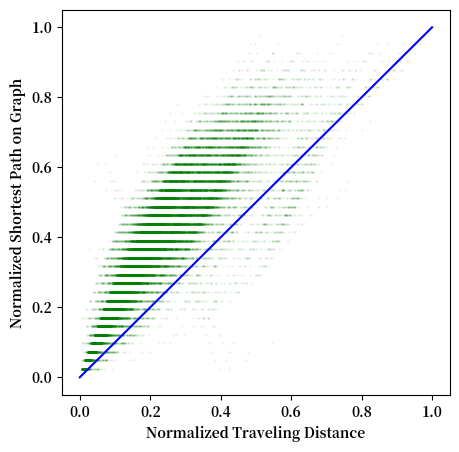

In [15]:
norm_dist_esti = dist_esti/np.max(dist_esti)
norm_dist_real = travelDis/np.max(travelDis)

plt.figure(figsize=(5,5))
for i in tqdm(range(len(stationID_List))):
    for j in range(i+1, len(stationID_List)):
        plt.plot(norm_dist_real[i,j], norm_dist_esti[i,j], '.' , markersize=1, alpha=0.1, color='green')

plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'b-', label='y=x') 
plt.xlabel('Normalized Traveling Distance')
plt.ylabel('Normalized Shortest Path on Graph')


API 得到的时间与距离之间的 Corr

100%|██████████| 302/302 [00:21<00:00, 14.28it/s]


Text(0, 0.5, 'Normalized Traveling Time')

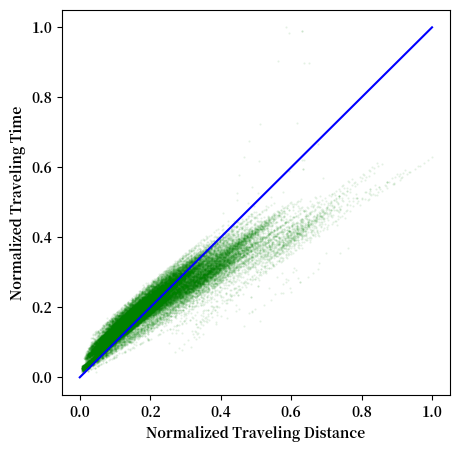

In [17]:
norm_travel_time= travelTime/np.max(travelTime)

plt.figure(figsize=(5,5))
for i in tqdm(range(len(stationID_List))):
    for j in range(i+1, len(stationID_List)):
        plt.plot(norm_dist_real[i,j], norm_travel_time[i,j], '.' , markersize=1, alpha=0.1, color='green')

plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'b-', label='y=x') 
plt.xlabel('Normalized Traveling Distance')
plt.ylabel('Normalized Traveling Time')

***
开始处理新的 metroData_ts.csv -> metroData_ts_v2.csv

In [2]:
from datetime import datetime, timedelta

def cal_startTime(endTime, time_div):
    endTime = str(endTime)
    endTime_obj = datetime.strptime(endTime,"%H%M%S")
    startTime_obj = endTime_obj - timedelta(seconds=time_div)
    endTime = datetime.strftime(startTime_obj,"%H%M%S")
    return endTime

def Add_startTime():

    with open('../../MetaData/travelTime.pkl','rb') as f:
        travelTime = pickle.load(f)

    stationInfo = pd.read_csv('../../Metro/station_transInfo_cleaned.csv')
    stationID_List = list(stationInfo['stationID'])

    transferStation, transferStationToNewID = pickle.load(open("../../Metro/transferStations.pkl",'rb')) # 只包含换乘站信息，前者字典后者list

    input_file = '../../Metro/metroData_ts.csv'
    # inData = open(input_file, 'r')
    # inDataList = list(inData)
    with open(input_file, 'r') as inData:
        inDataList = inData.readlines()

    print("File Loaded")

    outFile = "../../Metro/metroData_ts_v2.csv"
    outData = open(outFile, 'w')
    outData.writelines("UserID, Date, StartTime, EndTime, InStation, OutStation\n") 

    for row in tqdm(inDataList):
        row = row.rstrip().split(',')
        userID = int(row[0])
        transDay = row[1]
        transEndTime = row[2]

        inStation = int(row[3])
        outStation = int(row[4])

        # Updata Station ID
        try:
            inStation_new = transferStationToNewID[inStation]
        except:
            inStation_new = inStation
        try:
            outStation_new = transferStationToNewID[outStation]
        except:
            outStation_new = outStation

        if inStation_new not in stationID_List or outStation_new not in stationID_List: # 直接扔掉
            continue
        
        travelDuration = travelTime[stationID_List.index(inStation_new)][stationID_List.index(outStation_new)]
        transStartTime = cal_startTime(transEndTime, travelDuration)

        outData.writelines(','.join([str(userID), transDay, transStartTime , transEndTime, str(inStation_new), str(outStation_new)]) + '\n')

    outData.close()


In [3]:
Add_startTime()

File Loaded


100%|██████████| 736849643/736849643 [5:32:27<00:00, 36940.13it/s]   
